# Inspection of data from the Deutscher Wetter Dienst (german weather service)

## Collecting data on stations

In [1]:
from six.moves import urllib
from bs4 import BeautifulSoup
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [48]:
from bokeh import io, plotting, models, layouts
import ipywidgets # import interact

In [49]:
io.output_notebook()

Loading BokehJS ...

In [2]:
dwd_station_url = "https://www.dwd.de/DE/leistungen/klimadatendeutschland/statliste/statlex_html.html?view=nasPublication&nn=16102"

res = urllib.request.urlopen(dwd_station_url)
print("HTML code:", res.code)

HTML code: 200


In [3]:
file_path = "../data/dwd_stations.html"

print("Writing content to", file_path)
with open(file_path, "w") as f:
    content = res.read().decode("utf-8")
    
    f.write(content)

Writing content to ../data/dwd_stations.html


**Parsing html file**

In [117]:
file_path = "../data/dwd_stations.html"

print("Reading", file_path)
with open(file_path, "r") as f:
    content = f.readlines()
    
soup = BeautifulSoup("".join(content))

Reading ../data/dwd_stations.html


In [118]:
table = soup.find_all("tr")

columns = [e.text for e in table[1] if e.name == "th"]
station_data = pd.DataFrame(columns=columns)

for i,row in enumerate(table[2:]):
    
    if i % 1000 == 0: 
        print("Processed {:.2f} %".format(i/(len(table)-2)*100))
        
    values = [e.text for e in row.find_all("td")]
    
    station_data.loc[i] = values
    
station_data.head()

Processed 0.00 %
Processed 5.31 %
Processed 10.62 %
Processed 15.94 %
Processed 21.25 %
Processed 26.56 %
Processed 31.87 %
Processed 37.19 %
Processed 42.50 %
Processed 47.81 %
Processed 53.12 %
Processed 58.44 %
Processed 63.75 %
Processed 69.06 %
Processed 74.37 %
Processed 79.69 %
Processed 85.00 %
Processed 90.31 %
Processed 95.62 %


,Stationsname,Stations_ID,Kennung,Stations-kennung,Breite,Länge,Stations-höhe,Flussgebiet,Bundesland,Beginn,Ende
0,Aach,1,KL,02783,47.841,8.849,478,,BW,01.01.1937,30.06.1986
1,Aach,1,RR,70191,47.841,8.849,478,,BW,01.01.1912,30.06.1986
2,Aach/Hegau,10771,PE,10771,47.85,8.85,480,,BW,,
3,Aachen,3,EB,02205,50.7827,6.0941,202,803100,NW,01.01.1951,31.03.2011
4,Aachen,3,FF,02205,50.7827,6.0941,202,803100,NW,01.01.1937,31.03.2011


**Doing some tidying up**

In [114]:
pattern = r'^[\x00-\x08\x0b\x0c\x0e-\x1f\x7f-\xff]' # string begins with a special character
station_data.replace(to_replace={"Beginn": pattern, "Ende": pattern, "Flussgebiet": pattern}, 
                     regex=True, value='', inplace=True)

In [ ]:
schema = {
    "Stationsname": str, 
    "Stations_ID": str, 
    "Kennung": str,
    "Stations-kennung": str,
    "Breite": float,
    "Länge": float,
    "Stations-höhe": float,
    "Flussgebiet": int,
    "Bundesland": str,
    "Beginn": str,
    "Ende": str
}

for key, var_type in schema.items():
    station_data[key] = station_data[key].apply(var_type)

In [115]:
file_path = "../data/dwd_stations.csv"
print("Writing content to", file_path)
station_data.to_csv(file_path, index=False, sep=",")

Writing content to ../data/dwd_stations.csv


## Analyzing data on stations

In [4]:
file_path = "../data/dwd_stations.csv"

schema = {
    "Stationsname": str, 
    "Stations_ID": str, 
    "Kennung": str,
    "Stations-kennung": str,
    "Breite": float,
    "Länge": float,
    "Stations-höhe": float,
    "Flussgebiet": 'Int64',
    "Bundesland": str,
    "Beginn": str,
    "Ende": str
}

station_data = pd.read_csv(file_path, sep=",", dtype=schema)

station_data["Beginn"] = station_data["Beginn"].apply(pd.to_datetime)
station_data["Ende"] = station_data["Ende"].apply(pd.to_datetime)

station_data.head()

,Stationsname,Stations_ID,Kennung,Stations-kennung,Breite,Länge,Stations-höhe,Flussgebiet,Bundesland,Beginn,Ende
0,Aach,1,KL,02783,47.8410,8.8490,478.0,NaN,BW,1937-01-01,1986-06-30
1,Aach,1,RR,70191,47.8410,8.8490,478.0,NaN,BW,1912-01-01,1986-06-30
2,Aach/Hegau,10771,PE,10771,47.8500,8.8500,480.0,NaN,BW,NaT,NaT
3,Aachen,3,EB,02205,50.7827,6.0941,202.0,803100,NW,1951-01-01,2011-03-31
4,Aachen,3,FF,02205,50.7827,6.0941,202.0,803100,NW,1937-01-01,2011-03-31


In [5]:
print(station_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18824 entries, 0 to 18823
Data columns (total 11 columns):
Stationsname        18824 non-null object
Stations_ID         18824 non-null object
Kennung             18824 non-null object
Stations-kennung    18824 non-null object
Breite              18824 non-null float64
Länge               18824 non-null float64
Stations-höhe       18824 non-null float64
Flussgebiet         9984 non-null Int64
Bundesland          18824 non-null object
Beginn              12238 non-null datetime64[ns]
Ende                12238 non-null datetime64[ns]
dtypes: Int64(1), datetime64[ns](2), float64(3), object(5)
memory usage: 1.6+ MB
None


In [6]:
n = 3
num_rows = len(station_data)

for col in station_data.columns.values:
    
    vals = sorted(station_data[col].unique())
    lowest = vals[:n]
    highest = vals[-n:]
    
    s = """
column = '{col}'
    # unique values = {num_unique}
    duplicates = {duplicates:.2f} %
    lowest {n} = {lowest}
    highest {n} = {highest}""".format(col=col, num_unique=station_data[col].nunique(), n=n, lowest=lowest, 
                                      highest=highest, duplicates=(1-len(vals)/num_rows)*100)
    print(s)


column = 'Stationsname'
    # unique values = 12504
    duplicates = 33.57 %
    lowest 3 = ['Aach', 'Aach/Hegau', 'Aachen']
    highest 3 = ['Ülsby', 'Ürzig', 'Üschersdorf']

column = 'Stations_ID'
    # unique values = 12704
    duplicates = 32.51 %
    lowest 3 = ['1', '10', '100']
    highest 3 = ['9997', '9998', '9999']

column = 'Kennung'
    # unique values = 13
    duplicates = 99.93 %
    lowest 3 = ['AE', 'EB', 'EF']
    highest 3 = ['SO', 'SY', 'TU']

column = 'Stations-kennung'
    # unique values = 15219
    duplicates = 19.15 %
    lowest 3 = ['00001', '01007', '01020']
    highest 3 = ['Z002', 'Z003', 'Z004']

column = 'Breite'
    # unique values = 4055
    duplicates = 78.46 %
    lowest 3 = [47.271, 47.339, 47.36]
    highest 3 = [54.923, 55.0, 55.011]

column = 'Länge'
    # unique values = 4392
    duplicates = 76.67 %
    lowest 3 = [5.907, 5.983, 6.0]
    highest 3 = [14.982999999999999, 15.007, 15.033]

column = 'Stations-höhe'
    # unique values = 913
    dupl

E:\Programs\Anaconda3\envs\py37_tf\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  


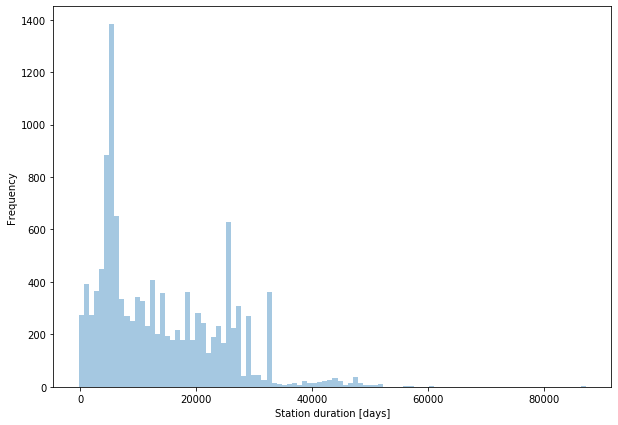

E:\Programs\Anaconda3\envs\py37_tf\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


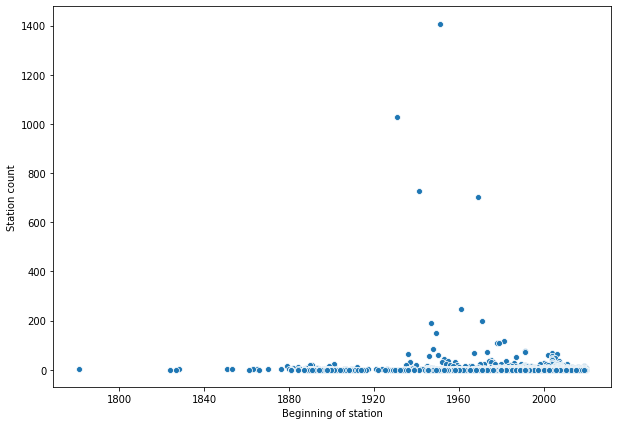

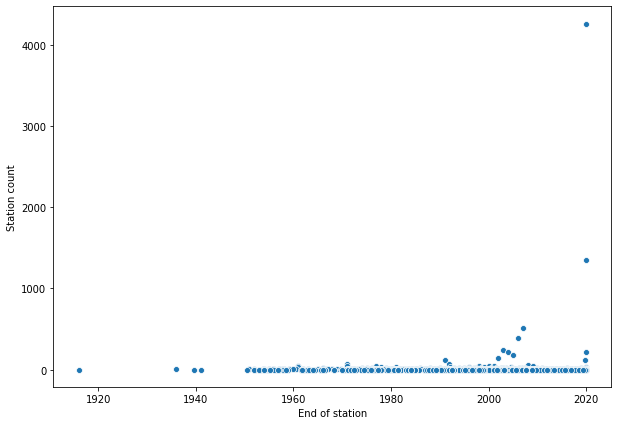

In [7]:
beginnings = station_data["Beginn"].value_counts()
endings = station_data["Ende"].value_counts()
deltas = (station_data["Ende"] - station_data["Beginn"]).dropna().astype("timedelta64[D]")

fig, ax = plt.subplots(figsize=(10,7))
sns.distplot(deltas, ax=ax, kde=False, bins=100)
ax.set_xlabel("Station duration [days]")
ax.set_ylabel("Frequency")
plt.show()

fig, ax = plt.subplots(figsize=(10,7))
sns.scatterplot(beginnings.index, beginnings.values, ax=ax)
ax.set_xlabel("Beginning of station")
ax.set_ylabel("Station count")
plt.show()

fig, ax = plt.subplots(figsize=(10,7))
sns.scatterplot(endings.index, endings.values, ax=ax)
ax.set_xlabel("End of station")
ax.set_ylabel("Station count")
plt.show()

In [8]:
station_data.head()
num_null_begin = station_data["Beginn"].isnull().sum()
print("Begin time stamps null = {} = {:.2f} %".format(num_null_begin, num_null_begin/len(station_data)*100))
num_null_end = station_data["Ende"].isnull().sum()
print("End time stamps null = {} = {:.2f} %".format(num_null_end, num_null_end/len(station_data)*100))

Begin time stamps null = 6586 = 34.99 %
End time stamps null = 6586 = 34.99 %


In [64]:
fig = plotting.figure(plot_width=600, plot_height=700, 
                      x_range=(station_data["Länge"].min(), station_data["Länge"].max()),
                      y_range=(station_data["Breite"].min(), station_data["Breite"].max()),
                      title="Locations of weather stations")

source = models.ColumnDataSource(data=station_data)

s = fig.circle(x="Länge", y="Breite", source=source)
fig.xaxis.axis_label = "Länge"
fig.yaxis.axis_label = "Breite"

hover = models.tools.HoverTool(tooltips=[
    ("Stationsname", "@Stationsname"),
    ("Stations ID", "@Stations_ID"),
    ("Kennung", "@Stations-kennung"),
    ("Bundesland", "@Bundesland"),
    ("Beginn", "@Beginn{%F}"),
    ("Ende", "@Ende{%F}")
],
                              formatters={"Ende": "datetime", "Beginn": "datetime"})
fig.add_tools(hover)

plotting.show(fig, notebook_handle=True)

def time_filter(t=(station_data["Beginn"].min(), station_data["Beginn"].max())):
    
    _df = station_data.loc[((station_data["Beginn"] >= t[0]) & (station_data["Beginn"] <= t[1])), :]
    s.data_source.data = models.ColumnDataSource(data=_df).data
    io.push_notebook()
    
date_range = pd.date_range(start=station_data["Beginn"].min(), end=station_data["Beginn"].max(), freq="1D")

options = [(date.strftime(' %d %b %Y '), date) for date in date_range]
index = (0, len(options)-1)

selection_range_slider = ipywidgets.SelectionRangeSlider(
    options=options,
    index=index,
    description='Dates',
    orientation='horizontal',
    layout={'width': '500px'}
)

ipywidgets.interact(time_filter, t=selection_range_slider)

interactive(children=(SelectionRangeSlider(description='Dates', index=(0, 87244), layout=Layout(width='500px')…

<function __main__.time_filter(t=(Timestamp('1781-01-01 00:00:00'), Timestamp('2019-11-14 00:00:00')))>

## Collecting annual data


https://opendata.dwd.de/climate_environment/CDC/


### Annual climate data
https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/annual/kl/historical/jahreswerte_KL_00001_19310101_19851231_hist.zip

In [88]:
save_dir = r"E:\PetProjects\Climate\surrealweather\data"

dwd_data_url = "https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/annual/kl/historical/jahreswerte_KL_00001_19310101_19851231_hist.zip"

res = urllib.request.urlopen(dwd_data_url)
print("HTML code:", res.code)

HTML code: 200


In [89]:
zip_file_path = "../data/jahreswerte_KL_00001_19310101_19851231_hist.zip"

print("Writing content to", file_path)
with open(zip_file_path, "wb") as f:
    content = res.read() #.decode("utf-8")
    
    f.write(content)

Writing content to ../data/jahreswerte_KL_00001_19310101_19851231_hist.zip


In [90]:
from zipfile import ZipFile

In [91]:
file_name = "produkt_klima_jahr_19310101_19851231_00001.txt"
save_dir = "../data/"

with ZipFile(zip_file_path, "r") as _zip:
    print(_zip.printdir())
    _zip.extract(file_name, path="../data/")
    
    
file_name = "Metadaten_Parameter_klima_jahr_00001.txt"
with ZipFile(zip_file_path, "r") as _zip:
    print(_zip.printdir())
    _zip.extract(file_name, path="../data/")

File Name                                             Modified             Size
Metadaten_Geographie_00001.txt                 2019-06-06 09:26:52          199
Metadaten_Geraete_Lufttemperatur_00001.html    2019-06-06 09:25:24         2884
Metadaten_Geraete_Lufttemperatur_00001.txt     2019-06-06 09:23:56          507
Metadaten_Geraete_Lufttemperatur_Maximum_00001.html 2019-06-06 09:25:24         2955
Metadaten_Geraete_Lufttemperatur_Maximum_00001.txt 2019-06-06 09:23:56          477
Metadaten_Geraete_Lufttemperatur_Minimum_00001.html 2019-06-06 09:25:24         2959
Metadaten_Geraete_Lufttemperatur_Minimum_00001.txt 2019-06-06 09:23:56          477
Metadaten_Geraete_Niederschlagshoehe_00001.html 2019-06-06 09:25:24         2847
Metadaten_Geraete_Niederschlagshoehe_00001.txt 2019-06-06 09:23:56          460
Metadaten_Parameter_klima_jahr_00001.html      2019-06-06 09:26:48        14202
Metadaten_Parameter_klima_jahr_00001.txt       2019-06-06 09:26:42         4512
Metadaten_Stationsnam

In [105]:
file_name = "Metadaten_Parameter_klima_jahr_00001.txt"
save_dir = "../data/"

with open(os.path.join(save_dir, file_name), "r") as f:
    
    df_climate_params = None
    for i, line in enumerate(f):
        
        if line.startswith("Legende:"):
            break
        if i == 0:
            df_climate_params = pd.DataFrame(columns=line.rstrip("\n").split(";"))
        else:
            df_climate_params.loc[i-1] = line.rstrip("\n").split(";")
        
#         if i > 3: break
            
df_climate_params.head()
# df_climate_params = pd.read_csv(os.path.join(save_dir, file_name), sep=";", encoding="utf8")
# df_climate_params

,Stations_ID,Von_Datum,Bis_Datum,Stationsname,Parameter,Parameterbeschreibung,Einheit,Datenquelle (Strukturversion=SV),Zusatz-Info,Besonderheiten,Literaturhinweis,eor,
0,1,19370101,19851231,Aach,JA_FK,Jahresmittel der Windstaerke,Bft,Klimadaten aus Klimaroutine des DWD (3 Termine...,arithm.Mittel aus Monatsmittelwerten,,,eor,
1,1,19310101,19361231,Aach,JA_MX_FX,Absolutes Maximum der Windmaxspitze,m/s,Monatswerte (Messnetz=4) ohne Tageswerte.,Extrema des Jahres,,,eor,
2,1,19370101,19851231,Aach,JA_MX_FX,Absolutes Maximum der Windmaxspitze,m/s,Klimadaten aus Klimaroutine des DWD (3 Termine...,Extrema des Jahres,,,eor,
3,1,18910101,19111231,Aach,JA_MX_RS,Maximale Niederschlagshoehe des Jahres,mm,Monatswerte (Messnetz=6) ohne Tageswerte,Extrema des Jahres,,,eor,
4,1,19120101,19301231,Aach,JA_MX_RS,Maximale Niederschlagshoehe des Jahres,mm,KLIDADIGI: Niederschlagsdaten nacherfasst (1 T...,Extrema des Jahres,,,eor,


In [106]:
import os
file_name = "produkt_klima_jahr_19310101_19851231_00001.txt"
save_dir = "../data/"

with open(os.path.join(save_dir, file_name), "r") as f:
    
    for i, line in enumerate(f):
        
        print("\nraw line:", line)
        
        if i > 3: break


raw line: STATIONS_ID;MESS_DATUM_BEGINN;MESS_DATUM_ENDE;QN_4;JA_N;JA_TT;JA_TX;JA_TN;JA_FK;JA_SD_S;JA_MX_FX;JA_MX_TX;JA_MX_TN;QN_6;JA_RR;JA_MX_RS;eor


raw line:           1;19310101;19311231;    5;  -999;   7.52;    -999;    2.53;-999;-999;-999;-999;-999;    5;   799.3;   33.5;eor


raw line:           1;19320101;19321231;    5;  -999;   8.12;    -999;    3.21;-999;-999;-999;-999;-999;    5;   640.4;   41.4;eor


raw line:           1;19330101;19331231;    5;  -999;   7.68;    -999;    2.55;-999;-999;-999;-999;-999;    5;   750.1;   42.2;eor


raw line:           1;19340101;19341231;    5;  -999;   9.31;    -999;    3.78;-999;-999;-999;-999;-999;    5;   638.8;   49.8;eor



In [107]:
df_climate = pd.read_csv(os.path.join(save_dir, file_name), sep=";")
df_climate.head()

,STATIONS_ID,MESS_DATUM_BEGINN,MESS_DATUM_ENDE,QN_4,JA_N,JA_TT,JA_TX,JA_TN,JA_FK,JA_SD_S,JA_MX_FX,JA_MX_TX,JA_MX_TN,QN_6,JA_RR,JA_MX_RS,eor
0,1,19310101,19311231,5,-999.0,7.52,-999.0,2.53,-999.0,-999,-999,-999.0,-999.0,5,799.3,33.5,eor
1,1,19320101,19321231,5,-999.0,8.12,-999.0,3.21,-999.0,-999,-999,-999.0,-999.0,5,640.4,41.4,eor
2,1,19330101,19331231,5,-999.0,7.68,-999.0,2.55,-999.0,-999,-999,-999.0,-999.0,5,750.1,42.2,eor
3,1,19340101,19341231,5,-999.0,9.31,-999.0,3.78,-999.0,-999,-999,-999.0,-999.0,5,638.8,49.8,eor
4,1,19350101,19351231,5,-999.0,8.41,-999.0,3.13,-999.0,-999,-999,-999.0,-999.0,5,824.7,26.4,eor


## Annual weather data

In [108]:
dwd_data_url = "https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/annual/weather_phenomena/historical/wetter_jahreswerte_00001_19370101_19860630_hist.zip"

res = urllib.request.urlopen(dwd_data_url)
print("HTML code:", res.code)

zip_file_path = "../data/wetter_jahreswerte_00001_19370101_19860630_hist.zip"

print("Writing content to", file_path)
with open(zip_file_path, "wb") as f:
    content = res.read() #.decode("utf-8")
    
    f.write(content)

HTML code: 200
Writing content to ../data/jahreswerte_KL_00001_19310101_19851231_hist.zip


In [109]:
file_name = "produkt_wetter_jahr_19370101_19860630_00001.txt"
save_dir = "../data/"

with ZipFile(zip_file_path, "r") as _zip:
    print(_zip.printdir())
    _zip.extract(file_name, path="../data/")
    
    
file_name = "Metadaten_Parameter_wetter_jahr_00001.txt"
with ZipFile(zip_file_path, "r") as _zip:
    print(_zip.printdir())
    _zip.extract(file_name, path="../data/")

File Name                                             Modified             Size
Metadaten_Geographie_00001.txt                 2019-09-06 13:10:46          199
Metadaten_Parameter_wetter_jahr_00001.html     2019-09-06 13:10:44         5612
Metadaten_Parameter_wetter_jahr_00001.txt      2019-09-06 13:10:34         1993
Metadaten_Stationsname_00001.html              2019-09-06 13:10:32          779
Metadaten_Stationsname_00001.txt               2019-09-06 13:10:30          111
produkt_wetter_jahr_19370101_19860630_00001.txt 2019-09-06 13:10:18         3864
None
File Name                                             Modified             Size
Metadaten_Geographie_00001.txt                 2019-09-06 13:10:46          199
Metadaten_Parameter_wetter_jahr_00001.html     2019-09-06 13:10:44         5612
Metadaten_Parameter_wetter_jahr_00001.txt      2019-09-06 13:10:34         1993
Metadaten_Stationsname_00001.html              2019-09-06 13:10:32          779
Metadaten_Stationsname_00001.txt  

In [111]:
file_name = "Metadaten_Parameter_wetter_jahr_00001.txt"
save_dir = "../data/"

with open(os.path.join(save_dir, file_name), "r") as f:
    
    df_weather_params = None
    for i, line in enumerate(f):
        
        if line.startswith("Legende:"):
            break
        if i == 0:
            df_weather_params = pd.DataFrame(columns=line.rstrip("\n").split(";"))
        else:
            df_weather_params.loc[i-1] = line.rstrip("\n").split(";")
        
#         if i > 3: break
            
df_weather_params.head()
# df_climate_params = pd.read_csv(os.path.join(save_dir, file_name), sep=";", encoding="utf8")
# df_climate_params

,Stations_ID,Von_Datum,Bis_Datum,Stationsname,Parameter,Parameterbeschreibung,Einheit,Datenquelle (Strukturversion=SV),Zusatz-Info,Besonderheiten,Literaturhinweis,eor,
0,1,19370101,19851231,Aach,JA_GEWITTER,Anzahl der Tage mit Gewitter im Jahr,NUMBER,Klimadaten aus Klimaroutine des DWD (3 Termine...,Anzahl Tage pro Monat,,,eor,
1,1,19370101,19860630,Aach,JA_GLATTEIS,Anzahl der Tage mit GLATTEIS im Jahr,NUMBER,Klimadaten aus Klimaroutine des DWD (3 Termine...,Anzahl Tage pro Monat,,,eor,
2,1,19370101,19851231,Aach,JA_HAGEL,Anzahl der Tage mit Hagel im Jahr,NUMBER,Klimadaten aus Klimaroutine des DWD (3 Termine...,Anzahl Tage pro Monat,,,eor,
3,1,19370101,19851231,Aach,JA_NEBEL,Anzahl der Tage mit Nebel im Jahr,NUMBER,Klimadaten aus Klimaroutine des DWD (3 Termine...,Anzahl Tage pro Monat,,,eor,
4,1,19370101,19851231,Aach,JA_STURM_6,Anzahl der Tage mit STURM>Bft6 im Jahr,NUMBER,Klimadaten aus Klimaroutine des DWD (3 Termine...,Anzahl Tage pro Monat,,,eor,


In [112]:
file_name = "produkt_wetter_jahr_19370101_19860630_00001.txt"
save_dir = "../data/"

df_weather = pd.read_csv(os.path.join(save_dir, file_name), sep=";")
df_weather.head()

,STATIONS_ID,MESS_DATUM_BEGINN,MESS_DATUM_ENDE,QN_4,JA_STURM_6,JA_STURM_8,JA_GEWITTER,JA_GLATTEIS,JA_GRAUPEL,JA_HAGEL,JA_NEBEL,JA_TAU,eor
0,1,19370101,19371231,5,0,0,0,0,0,0,0,0,eor
1,1,19380101,19381231,5,0,0,0,0,0,0,0,0,eor
2,1,19390101,19391231,5,0,0,0,0,0,0,0,0,eor
3,1,19400101,19401231,5,0,0,0,0,0,0,0,0,eor
4,1,19410101,19411231,5,0,0,0,0,0,0,0,0,eor
